# Dashboard to look at impact tracker results for various experiment sets

## Datasets
- ukb pilot [cohort](https://github.com/neurodatascience/watts_up_compute/blob/impact_tracker/subject_lists/ukb_pilot_subjects.csv)

## Pipelines
- FreeSurfer: recon-all (1,2,3 stages)
- FastSurfer: FastSurferCNN (volumetric segmentation)

## Monitoring metrics
- experiment duration in hours
- power consumption in kWh (kilo-watt-hours) 

In [2]:
import sys
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from utils.dashboard_utils import * 

from experiment_impact_tracker.data_interface import DataInterface
from experiment_impact_tracker.data_utils import *
from experiment_impact_tracker.data_utils import (load_data_into_frame,
                                                  load_initial_info,
                                                  zip_data_and_info)

ModuleNotFoundError: No module named 'utils'

In [2]:
project_dir = '../'
fastsurfer_exp_dir = '{}/FastSurfer_experiments/'.format(project_dir)
preproc_exp_dir = '{}/preproc_pipeline_experiments/'.format(project_dir)
fastsurfer_results_dir = '{}results/exp_impact_tracker/'.format(fastsurfer_exp_dir)
preproc_results_dir = '{}results/exp_impact_tracker/'.format(preproc_exp_dir)
subject_lists = '{}subject_lists/ukb_pilot_subjects.csv'.format(project_dir)

FastCNN_dir = fastsurfer_results_dir + 'ukb/FastCNN/'
FastRecon_dir = fastsurfer_results_dir + 'ukb/FastRecon/'

### Custom set of trial expeirments

In [ ]:
experiment_dict = {
                   'FastSurfer_local_cpu':('{}/track_sub_000_benchmark/'.format(fastsurfer_results_dir),False), 
                   'FastSurfer_CC_cpu':('{}/CC_cpu_test/'.format(fastsurfer_results_dir),False),
                   'FastSurfer_CC_gpu':('{}/CC_gpu_test/'.format(fastsurfer_results_dir),True),
                   'autorecon1_local_test_1':('{}/ReconAll_test_local_cpu/'.format(preproc_results_dir),False),
                   'autorecon2-3_local_test_1':('{}/ReconAll_test_location_override/'.format(preproc_results_dir),False),
                   'autorecon1_CC_test_1':('{}/ReconAll_test_CC_cpu/'.format(preproc_results_dir),False),
                   'autorecon1_CC_ukb_1':('{}/ReconAll_ukb_CC_cpu/'.format(preproc_results_dir),False)
                   }

read_flops = True

power_df_concat = pd.DataFrame()
flops_df_concat = pd.DataFrame()
tracker_summary_df_concat = pd.DataFrame()

for k,v in experiment_dict.items():
    power_df, flops_df, tracker_summary_df = get_tracker_data(k, v[0], v[1], read_flops)
    power_df_concat = power_df_concat.append(power_df)
    flops_df_concat = flops_df_concat.append(flops_df)
    tracker_summary_df_concat = tracker_summary_df_concat.append(tracker_summary_df)
    


In [ ]:
exp_set = 'trial_runs'
cpu_info_df = pd.DataFrame(columns=['experiment_set','experiment_name','brand','usable_cpus'])
i = 0
for exp_name,exp_config in experiment_dict.items():
    tracker_log_dir = exp_config[0] 
    info = load_initial_info(tracker_log_dir)
    usable_cpus = info['cpu_info']['usable_cpus']
    brand = info['cpu_info']['brand_raw']
    cpu_info_df.loc[i] = [exp_set,exp_name,brand,usable_cpus]
    i = i + 1
    
cpu_info_df

In [ ]:
plot_df = tracker_summary_df_concat.copy()
plot_df['total_duration (s)'] = plot_df['total_duration_impact_tracker'] * 3600
plot_df['total_power (watt-hr)'] = plot_df['total_power'] * 1000
plot_df['avg_power (watts)'] = 1000 * plot_df['total_power'] / plot_df['total_duration_impact_tracker'] 

sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1,3, figsize=(24,8),sharex=False,sharey=False)
    ax = axes[0]
    g = sns.scatterplot(y='total_power (watt-hr)', x='total_duration (s)', hue='experiment_name', s=100, data=plot_df, ax=ax)
    # g.set(xscale='log',yscale='log') 
    g.legend(fontsize=12)

    ax = axes[1]
    g = sns.barplot(y='avg_power (watts)', x='experiment_name', data=plot_df, ax=ax)
    g.set_xticklabels(g.get_xticklabels(),rotation=50,fontsize=12)

    ax = axes[2]
    plot_df = flops_df_concat.copy()
    g = sns.scatterplot(y='power', x='DP', hue='experiment_name', style='task', s=100, data=plot_df, ax=ax)
    g.set(xscale='log',yscale='log') 
    g.legend(fontsize=12)

### UKB pilot experiment sets
- recon-all 
- fastsurfer
    - pruning_{0,25,50}
    - gpu/cpu

In [3]:
subject_df = pd.read_csv(subject_lists)
subject_ids = subject_df['eid']

ignore_subjects = {1009760}
subject_ids = list(set(subject_ids) - ignore_subjects)

print('Found {} subjects'.format(len(subject_ids)))

Found 72 subjects


In [4]:
save_perf = False

experiment_sets = {
                ## FreeSurfer baseline
                   'recon-all_run_1':(preproc_results_dir + 'ukb/run_1/', False), # log_dir, use_cuda
                   'recon-all_run_2':(preproc_results_dir + 'ukb/run_2/', False), # log_dir, use_cuda

                ## FastSurferCNN run1 cpu
                #    'fastsurferCNN_run1_cpu_prune_0':(FastCNN_dir + 'run_1/cpu/prune_0/', False), # log_dir, use_cuda 
                #    'fastsurferCNN_run1_cpu_prune_25':(FastCNN_dir + 'run_1/cpu/prune_25/', False), # log_dir, use_cuda 
                #    'fastsurferCNN_run1_cpu_prune_50':(FastCNN_dir + 'run_1/cpu/prune_50/', False), # log_dir, use_cuda 
                
                ## FastSurferCNN run1 gpu
                #    'fastsurferCNN_run1_gpu_prune_0':(FastCNN_dir + 'run_1/gpu/prune_0/', True), # log_dir, use_cuda
                #    'fastsurferCNN_run1_gpu_prune_25':(FastCNN_dir + 'run_1/gpu/prune_25/', True), # log_dir, use_cuda
                #    'fastsurferCNN_run1_gpu_prune_50':(FastCNN_dir + 'run_1/gpu/prune_50/', True), # log_dir, use_cuda

                ## FastSurferCNN run2 cpu
                #    'fastsurferCNN_run2_cpu_prune_0':(FastCNN_dir + 'run_2/cpu/prune_0/', False), # log_dir, use_cuda 
                #    'fastsurferCNN_run2_cpu_prune_25':(FastCNN_dir + 'run_2/cpu/prune_25/', False), # log_dir, use_cuda
                #    'fastsurferCNN_run2_cpu_prune_50':(FastCNN_dir + 'run_2/cpu/prune_50/', False), # log_dir, use_cuda

                ## FastSurferCNN run2 gpu
                #    'fastsurferCNN_run2_gpu_prune_0':(FastCNN_dir + 'run_2/gpu/prune_0/', True), # log_dir, use_cuda
                #    'fastsurferCNN_run2_gpu_prune_25':(FastCNN_dir + 'run_2/gpu/prune_25/', True), # log_dir, use_cuda
                #    'fastsurferCNN_run2_gpu_prune_50':(FastCNN_dir + 'run_2/gpu/prune_50/', True), # log_dir, use_cuda

                ## FastSurferCNN run3 cpu
                   'fastsurferCNN_run3_cpu_prune_0':(FastCNN_dir + 'run_3/cpu/prune_0/', False), # log_dir, use_cuda 
                   'fastsurferCNN_run3_cpu_prune_25':(FastCNN_dir + 'run_3/cpu/prune_25/', False), # log_dir, use_cuda
                   'fastsurferCNN_run3_cpu_prune_50':(FastCNN_dir + 'run_3/cpu/prune_50/', False), # log_dir, use_cuda
                
                ## FastSurferRecon run1 cpu
                #    'fastsurferRecon_run1_cpu_prune_0':(FastRecon_dir + 'run_1/', False), # log_dir, use_cuda
                  }


for exp_set, exp_config in experiment_sets.items(): 
    print('Reading logs for: {}'.format(exp_config[0]))
    tracker_log_dir = exp_config[0]
    use_cuda = exp_config[1]
    # try:
    tracker_summary_df_concat, flops_df_concat, power_df_concat = collate_tracker_data(tracker_log_dir, subject_ids, use_cuda, read_flops)
    tracker_summary_df_concat['experiment_set'] = exp_set
    flops_df_concat['experiment_set'] = exp_set
    power_df_concat['experiment_set'] = exp_set
    
    if save_perf:
        tracker_summary_df_concat.to_csv('{}{}'.format(tracker_log_dir,'tracker_summary_df_concat.csv'))
        flops_df_concat.to_csv('{}{}'.format(tracker_log_dir,'flops_df_concat.csv'))
        power_df_concat.to_csv('{}{}'.format(tracker_log_dir,'power_df_concat.csv'))
    # except Exception as e:
    #     print(e)
    #     continue

Reading logs for: ..//preproc_pipeline_experiments/results/exp_impact_tracker/ukb/run_1/
../../experiment-impact-tracker/experiment_impact_tracker/data_utils.py:30: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  return json_normalize(json_array, max_level=max_level), json_array
../lib/dashboard_utils.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_df['total_attributable_power_draw'] = power_df['rapl_estimated_attributable_power_draw']
../lib/dashboard_utils.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

### Collate saved tracker perf

In [4]:
tracker_summary_df_concat_exp_set = pd.DataFrame()
flops_df_concat_exp_set = pd.DataFrame()
power_df_concat_exp_set = pd.DataFrame()

experiment_sets = {
                ## FreeSurfer baseline
                   'recon-all_run_1':(preproc_results_dir + 'ukb/run_1/', False), # log_dir, use_cuda
                  #  'recon-all_run_2':(preproc_results_dir + 'ukb/run_2/', False), # log_dir, use_cuda

                ## FastSurferCNN run1 cpu (possibly bad)
                  #  'fastsurferCNN_run1_cpu_prune_0':(FastCNN_dir + 'run_1/cpu/prune_0/', False), # log_dir, use_cuda 
                  #  'fastsurferCNN_run1_cpu_prune_25':(FastCNN_dir + 'run_1/cpu/prune_25/', False), # log_dir, use_cuda 
                  #  'fastsurferCNN_run1_cpu_prune_50':(FastCNN_dir + 'run_1/cpu/prune_50/', False), # log_dir, use_cuda 
                
                ## FastSurferCNN run1 gpu
                   'fastsurferCNN_run1_gpu_prune_0':(FastCNN_dir + 'run_1/gpu/prune_0/', True), # log_dir, use_cuda
                  #  'fastsurferCNN_run1_gpu_prune_25':(FastCNN_dir + 'run_1/gpu/prune_25/', True), # log_dir, use_cuda
                  #  'fastsurferCNN_run1_gpu_prune_50':(FastCNN_dir + 'run_1/gpu/prune_50/', True), # log_dir, use_cuda

                ## FastSurferCNN run2 cpu (ovewritten bad)
                  #  'fastsurferCNN_run2_cpu_prune_0':(FastCNN_dir + 'run_2/cpu/prune_0/', False), # log_dir, use_cuda 
                  #  'fastsurferCNN_run2_cpu_prune_25':(FastCNN_dir + 'run_2/cpu/prune_25/', False), # log_dir, use_cuda
                  #  'fastsurferCNN_run2_cpu_prune_50':(FastCNN_dir + 'run_2/cpu/prune_50/', False), # log_dir, use_cuda

                ## FastSurferCNN run2 gpu
                  #  'fastsurferCNN_run2_gpu_prune_0':(FastCNN_dir + 'run_2/gpu/prune_0/', True), # log_dir, use_cuda
                  #  'fastsurferCNN_run2_gpu_prune_25':(FastCNN_dir + 'run_2/gpu/prune_25/', True), # log_dir, use_cuda
                  #  'fastsurferCNN_run2_gpu_prune_50':(FastCNN_dir + 'run_2/gpu/prune_50/', True), # log_dir, use_cuda

               ## FastSurferCNN run3 cpu
                   'fastsurferCNN_run3_cpu_prune_0':(FastCNN_dir + 'run_3/cpu/prune_0/', False), # log_dir, use_cuda 
                  #  'fastsurferCNN_run3_cpu_prune_25':(FastCNN_dir + 'run_3/cpu/prune_25/', False), # log_dir, use_cuda
                  #  'fastsurferCNN_run3_cpu_prune_50':(FastCNN_dir + 'run_3/cpu/prune_50/', False), # log_dir, use_cuda
                
                ## FastSurferRecon run1 cpu
                   'fastsurferRecon_run1_cpu_prune_0':(FastRecon_dir + 'run_1/', False), # log_dir, use_cuda
                  }

for exp_set, exp_config in experiment_sets.items(): 

   tracker_log_dir = exp_config[0]
   
   try:
      tracker_summary_df_concat = pd.read_csv('{}{}'.format(tracker_log_dir,'tracker_summary_df_concat.csv'))
      flops_df_concat = pd.read_csv('{}{}'.format(tracker_log_dir,'flops_df_concat.csv'))
      power_df_concat = pd.read_csv('{}{}'.format(tracker_log_dir,'power_df_concat.csv'))

      tracker_summary_df_concat_exp_set = tracker_summary_df_concat_exp_set.append(tracker_summary_df_concat)
      flops_df_concat_exp_set = flops_df_concat_exp_set.append(flops_df_concat)
      power_df_concat_exp_set = power_df_concat_exp_set.append(power_df_concat)

   except Exception as e:
        print(e)
        continue

### Grab CPU/GPU info from the tracker logs

In [5]:
exp_names = tracker_summary_df_concat['experiment_name'].values

cpu_info_df = pd.DataFrame(columns=['experiment_set','experiment_name','brand','usable_cpus'])

i = 0
for exp_set, exp_config in experiment_sets.items(): 
    print('exp set: {}'.format(exp_set))
    for exp_name in exp_names:
        try:
            tracker_log_dir = exp_config[0] + '/sub-{}'.format(int(exp_name))
            info = load_initial_info(tracker_log_dir)
            usable_cpus = info['cpu_info']['usable_cpus']
            brand = info['cpu_info']['brand_raw']
            cpu_info_df.loc[i] = [exp_set,exp_name,brand,usable_cpus]
            i = i + 1
        except Exception as e:
            print(exp_name, e)
            continue

# example run info across experiment sets
cpu_info_df[cpu_info_df['experiment_name']==1474044]

exp set: recon-all_run_1
exp set: fastsurferCNN_run1_gpu_prune_0
exp set: fastsurferCNN_run3_cpu_prune_0
exp set: fastsurferRecon_run1_cpu_prune_0


,experiment_set,experiment_name,brand,usable_cpus
71,recon-all_run_1,1474044.0,Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz,1
143,fastsurferCNN_run1_gpu_prune_0,1474044.0,Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz,16
215,fastsurferCNN_run3_cpu_prune_0,1474044.0,Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz,1
287,fastsurferRecon_run1_cpu_prune_0,1474044.0,Intel(R) Xeon(R) Gold 6148 CPU @ 2.40GHz,1


## Total power usage per experiment (i.e. subject)

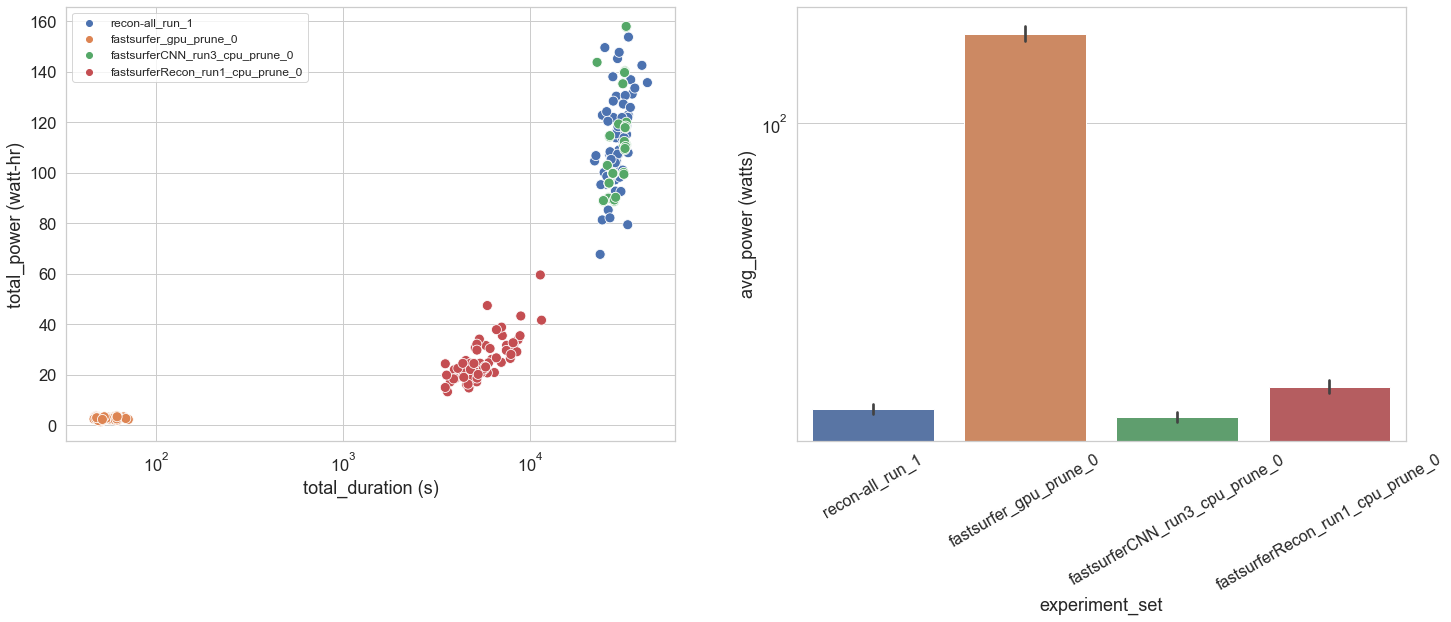

In [52]:
plot_df = tracker_summary_df_concat_exp_set.copy()
plot_df['total_duration (s)'] = plot_df['total_duration_impact_tracker'] * 3600
plot_df['total_power (watt-hr)'] = plot_df['total_power'] * 1000
plot_df['avg_power (watts)'] = 1000 * plot_df['total_power'] / plot_df['total_duration_impact_tracker'] 

sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1,2, figsize=(24,8),sharex=False,sharey=False)
    ax = axes[0]
    g = sns.scatterplot(y='total_power (watt-hr)', x='total_duration (s)', hue='experiment_set', s=100, data=plot_df, ax=ax)
    # g = sns.barplot(y='total_power (watt-hr)', x='experiment_set',  data=plot_df, ax=ax)
    g.set(xscale='log') 
    g.legend(fontsize=12)

    ax = axes[1]
    g = sns.barplot(y='avg_power (watts)', x='experiment_set', data=plot_df, ax=ax)
    g.set_xticklabels(g.get_xticklabels(),rotation=30,fontsize=16)
    g.set(yscale='log') 



## Aggregate experiment sets for FastSurfer
- fastsurfer_cpu + fastsurfer_recon-surf and fastsurfer_gpu + fastsurfer_recon-surf
- compare it with freesurfer recon-all

In [5]:
tracker_summary_df_concat_exp_set = tracker_summary_df_concat_exp_set[tracker_summary_df_concat_exp_set['experiment_name'].isin(subject_ids)]
print(tracker_summary_df_concat_exp_set.shape)
tracker_df_recon_all = tracker_summary_df_concat_exp_set[tracker_summary_df_concat_exp_set['experiment_set']=='recon-all_run_1'].copy()
tracker_df_recon_all['experiment_set'] = 'FreeSurfer'

tracker_df_fastsurfer_cpu = tracker_summary_df_concat_exp_set[tracker_summary_df_concat_exp_set['experiment_set'].isin(['fastsurferCNN_run3_cpu_prune_0','fastsurferRecon_run1_cpu_prune_0'])].copy()
tracker_df_fastsurfer_gpu = tracker_summary_df_concat_exp_set[tracker_summary_df_concat_exp_set['experiment_set'].isin(['fastsurfer_gpu_prune_0','fastsurferRecon_run1_cpu_prune_0'])].copy()

print(tracker_df_recon_all.shape,tracker_df_fastsurfer_cpu.shape,tracker_df_fastsurfer_gpu.shape)

### This is sanity-checked
tracker_df_fastsurfer_cpu = tracker_df_fastsurfer_cpu.groupby(['experiment_name','PUE']).sum().reset_index()
tracker_df_fastsurfer_gpu = tracker_df_fastsurfer_gpu.groupby(['experiment_name','PUE']).sum().reset_index()

tracker_df_fastsurfer_cpu['experiment_set'] = 'FastSurfer_cpu'
tracker_df_fastsurfer_gpu['experiment_set'] = 'FastSurfer_gpu'

(288, 8)
(72, 8) (144, 8) (144, 8)


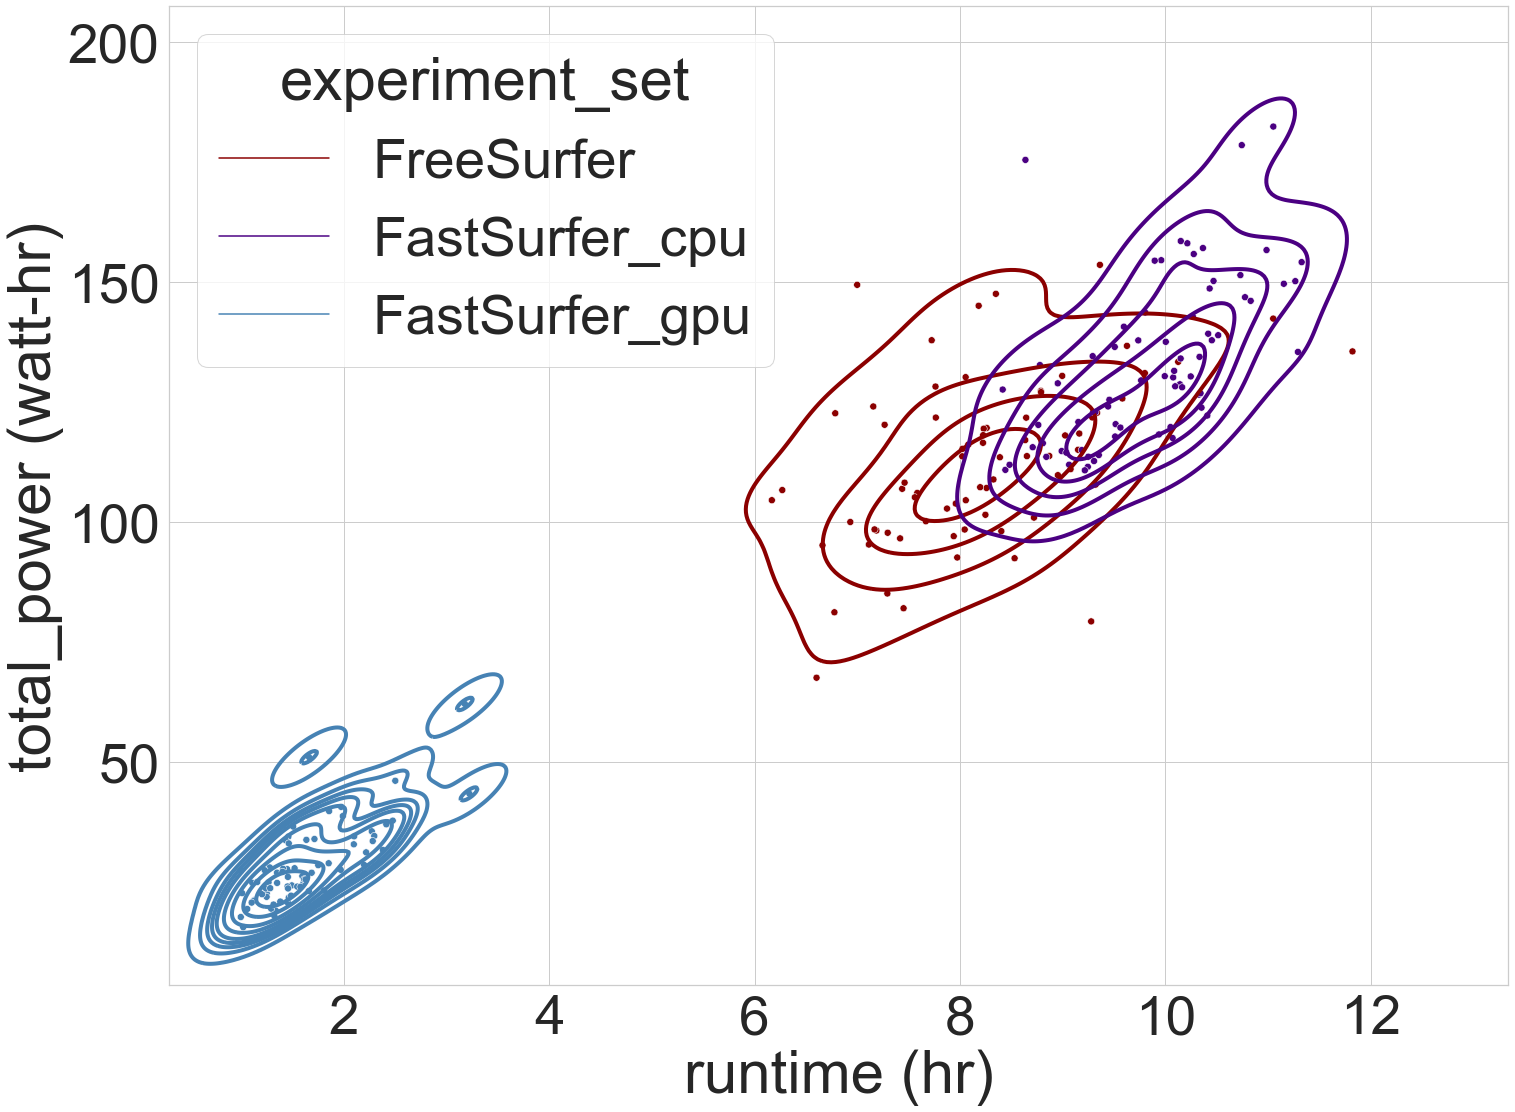

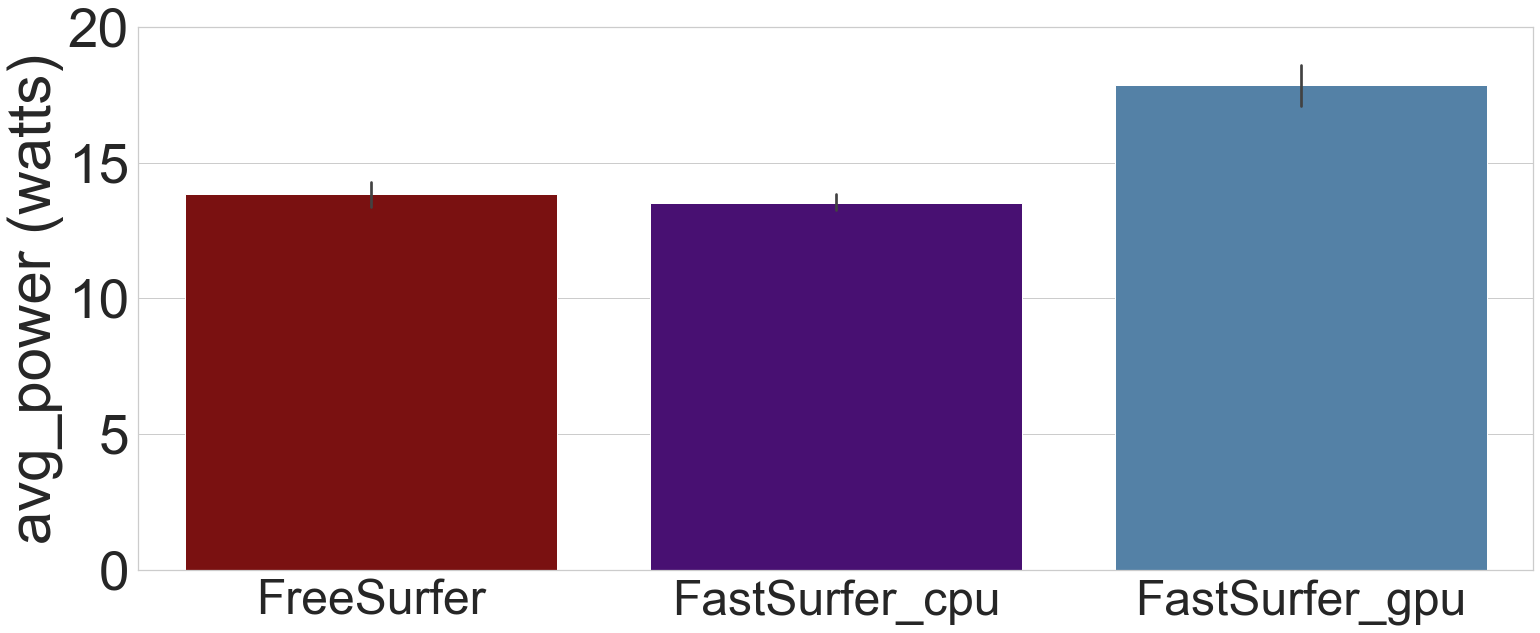

In [6]:
plot_df = tracker_df_recon_all.append(tracker_df_fastsurfer_cpu).append(tracker_df_fastsurfer_gpu).copy()
plot_df['runtime (hr)'] = plot_df['total_duration_impact_tracker']
plot_df['runtime (s)'] = plot_df['total_duration_impact_tracker'] * 3600
plot_df['runtime (min)'] = plot_df['total_duration_impact_tracker'] * 60
plot_df['total_power (watt-hr)'] = plot_df['total_power'] * 1000
plot_df['avg_power (watts)'] = 1000 * plot_df['total_power'] / plot_df['total_duration_impact_tracker'] 

# mpl.rc('lines', linewidth=10)
mpl.rcParams["contour.linewidth"] = 4
sns.set(font_scale = 5)
exp_set_palette = ['darkred','indigo','steelblue'] #
# palette = sns.color_palette("husl",3)
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(24,18),sharex=False,sharey=False)
    g = sns.scatterplot(y='total_power (watt-hr)', x='runtime (hr)', hue='experiment_set', s=50, data=plot_df, ax=ax, palette=exp_set_palette)
    g = sns.kdeplot(y='total_power (watt-hr)', x='runtime (hr)', hue='experiment_set', data=plot_df, ax=ax, palette=exp_set_palette)
    # g = sns.barplot(y='total_power (watt-hr)', x='experiment_set',  data=plot_df, ax=ax)
    # g.set(xscale='log') 
    # g.legend(fontsize=12)


with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(25,10),sharex=False,sharey=False)
    g = sns.barplot(y='avg_power (watts)', x='experiment_set', data=plot_df, ax=ax, palette=exp_set_palette)
    g.set_xticklabels(g.get_xticklabels(),rotation=0,fontsize=48)
    g.set(xlabel = "", ylim=[0, 20])
    # g.set(yscale='log') 
    
    



In [10]:
plot_df.groupby(['experiment_set','PUE']).std()

,,Unnamed: 0,experiment_name,total_power,total_carbon,total_duration_papi,total_duration_impact_tracker,runtime (hr),runtime (s),runtime (min),total_power (watt-hr),avg_power (watts)
experiment_set,PUE,,,,,,,,,,,
FastSurfer_cpu,1.58,0.0,1.234432e+06,0.017030,0.000511,0.742104,0.742115,0.742115,2671.613656,44.526894,17.030476,1.411145
FastSurfer_gpu,1.58,0.0,1.234432e+06,0.008154,0.000245,0.474252,0.474462,0.474462,1708.064631,28.467744,8.154039,3.489256
FreeSurfer,1.58,0.0,1.234432e+06,0.017200,0.000516,1.031708,1.031714,1.031714,3714.171842,61.902864,17.200216,2.071271


### Flops vs Power

## Aggregate experiment sets for FastSurfer
- ExpSets: freesurfer vs FastSurfer
- Tasks: autorecon_{1,2,3}, CNN_{setup,axial,coronal,sagittal,postproc}, recon-surf
- proc: cpu vs gpu

In [31]:
flops_df_freesurfer = flops_df_concat_exp_set[flops_df_concat_exp_set['experiment_set']=='recon-all_run_1'].copy()
flops_df_freesurfer['experiment_set'] = 'FreeSurfer'
flops_df_freesurfer['proc'] = 'cpu'
flops_df_freesurfer['task'] = flops_df_freesurfer['task'] + "_" + flops_df_freesurfer['proc']

flops_df_fastsurfer = flops_df_concat_exp_set[flops_df_concat_exp_set['experiment_set'].isin(['fastsurfer_gpu_prune_0','fastsurferCNN_run3_cpu_prune_0','fastsurferRecon_run1_cpu_prune_0'])].copy()
flops_df_fastsurfer['proc'] = 'cpu'
flops_df_fastsurfer.loc[flops_df_fastsurfer['experiment_set']=='fastsurfer_gpu_prune_0','proc'] = 'gpu'

flops_df_fastsurfer['task'] = flops_df_fastsurfer['task'].replace({'setup':'Fast_seg-CNN','axial':'Fast_seg-CNN','Coronal':'Fast_seg-CNN','Sagittal':'Fast_seg-CNN','aggregate':'Fast_seg-CNN','recon':'Fast_recon-surf'})
flops_df_fastsurfer['task'] = flops_df_fastsurfer['task'] + "_" + flops_df_fastsurfer['proc']

# sum up all the sub-tasks for each subject
flops_df_fastsurfer = flops_df_fastsurfer.groupby(['experiment_name','task']).sum().reset_index()

flops_df_fastsurfer['experiment_set'] = 'FastSurfer'

print(flops_df_concat_exp_set.shape,flops_df_freesurfer.shape, flops_df_fastsurfer.shape)

(1013, 11) (216, 12) (217, 11)


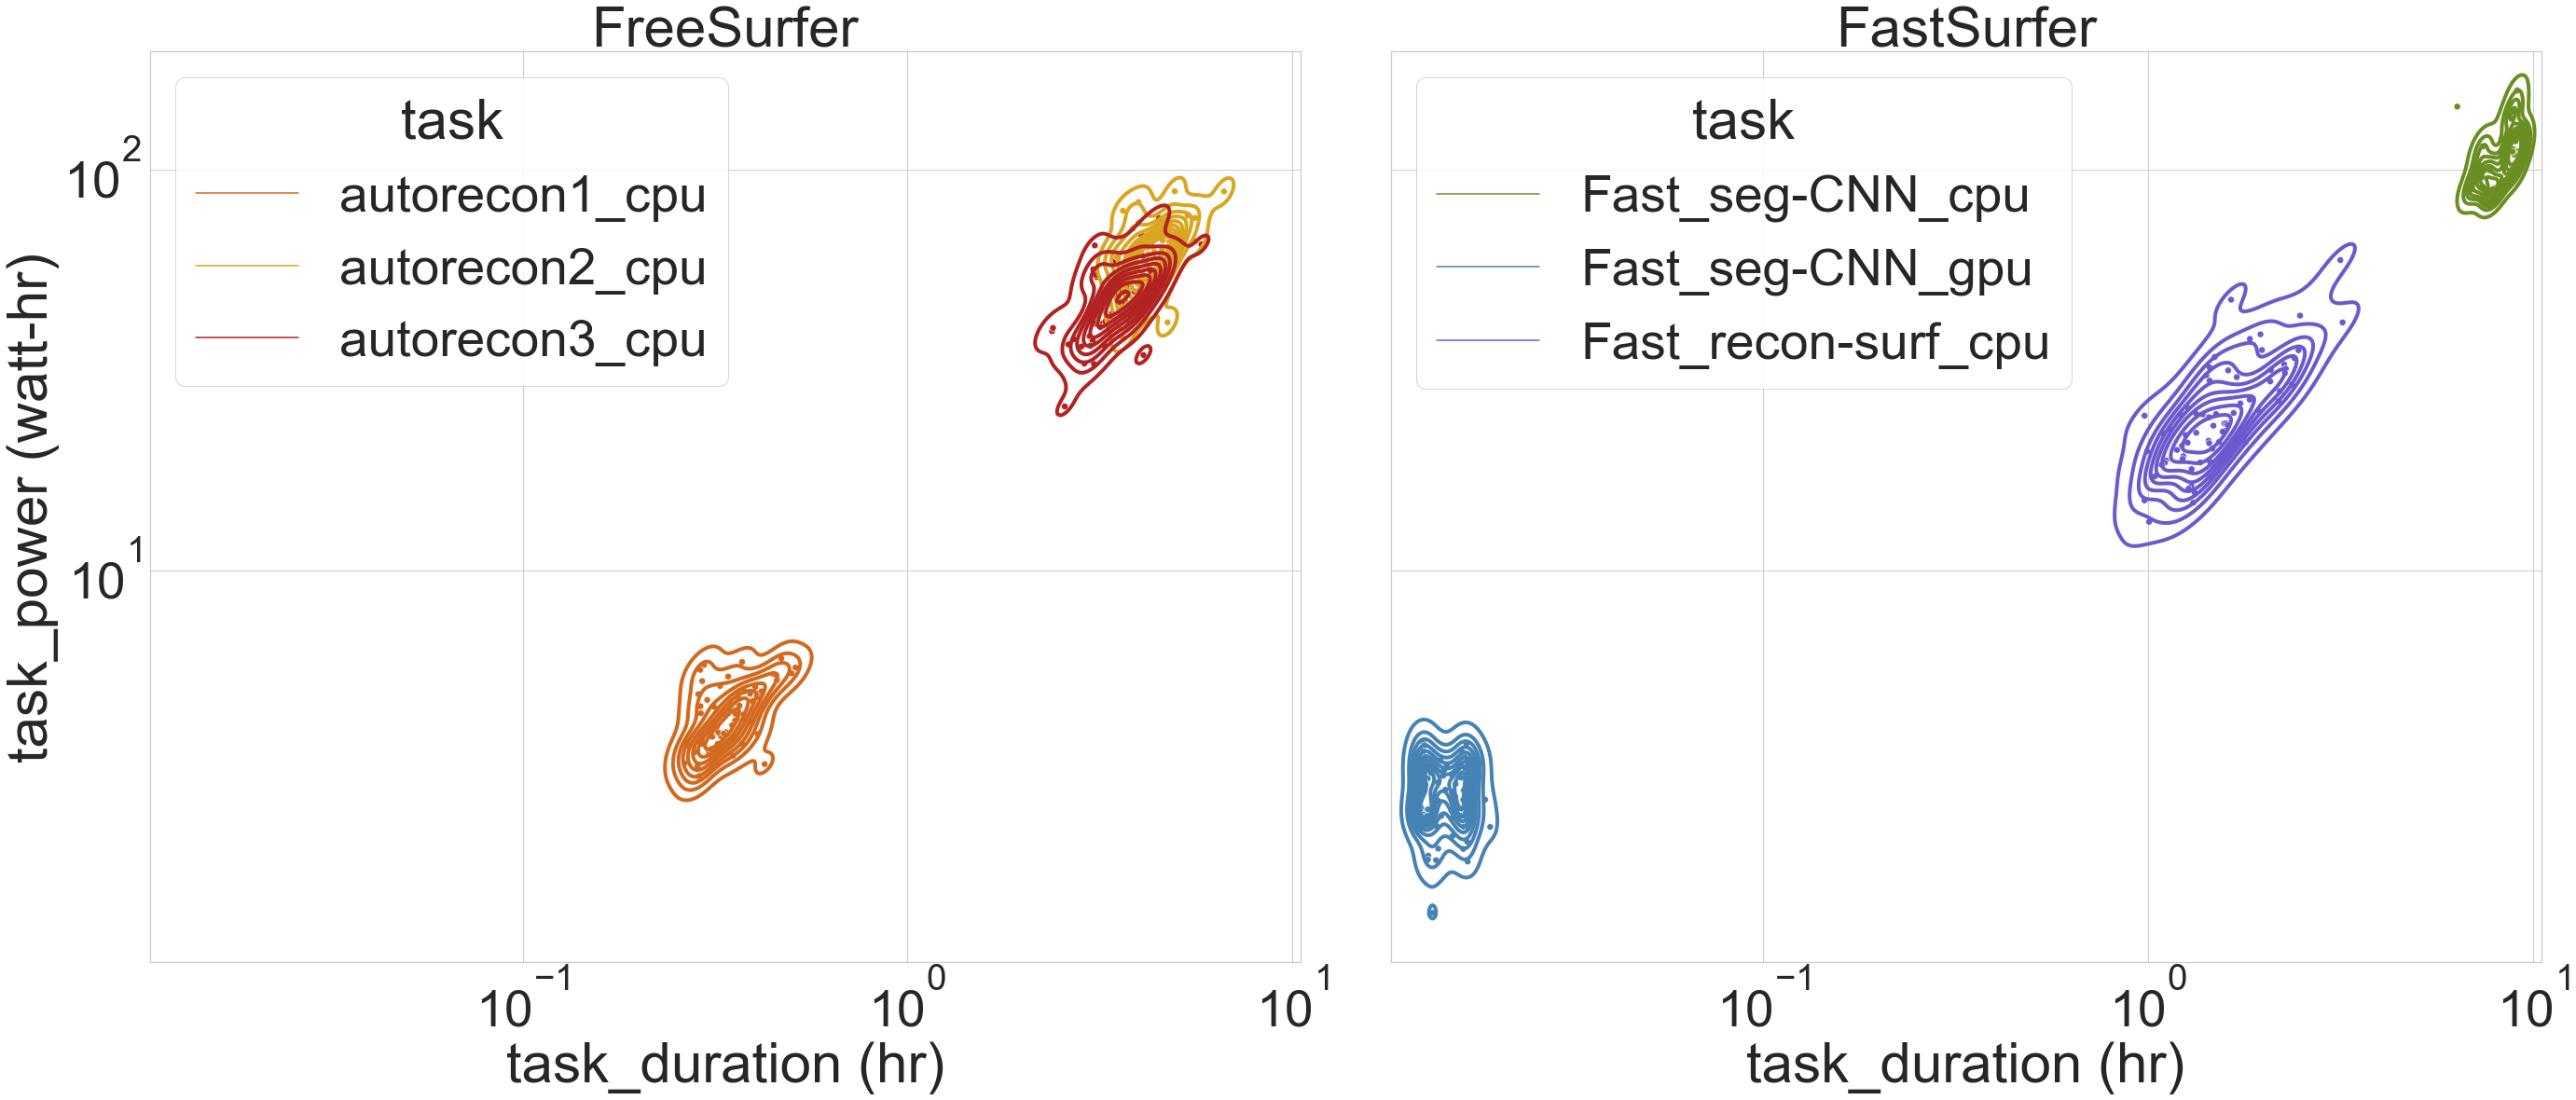

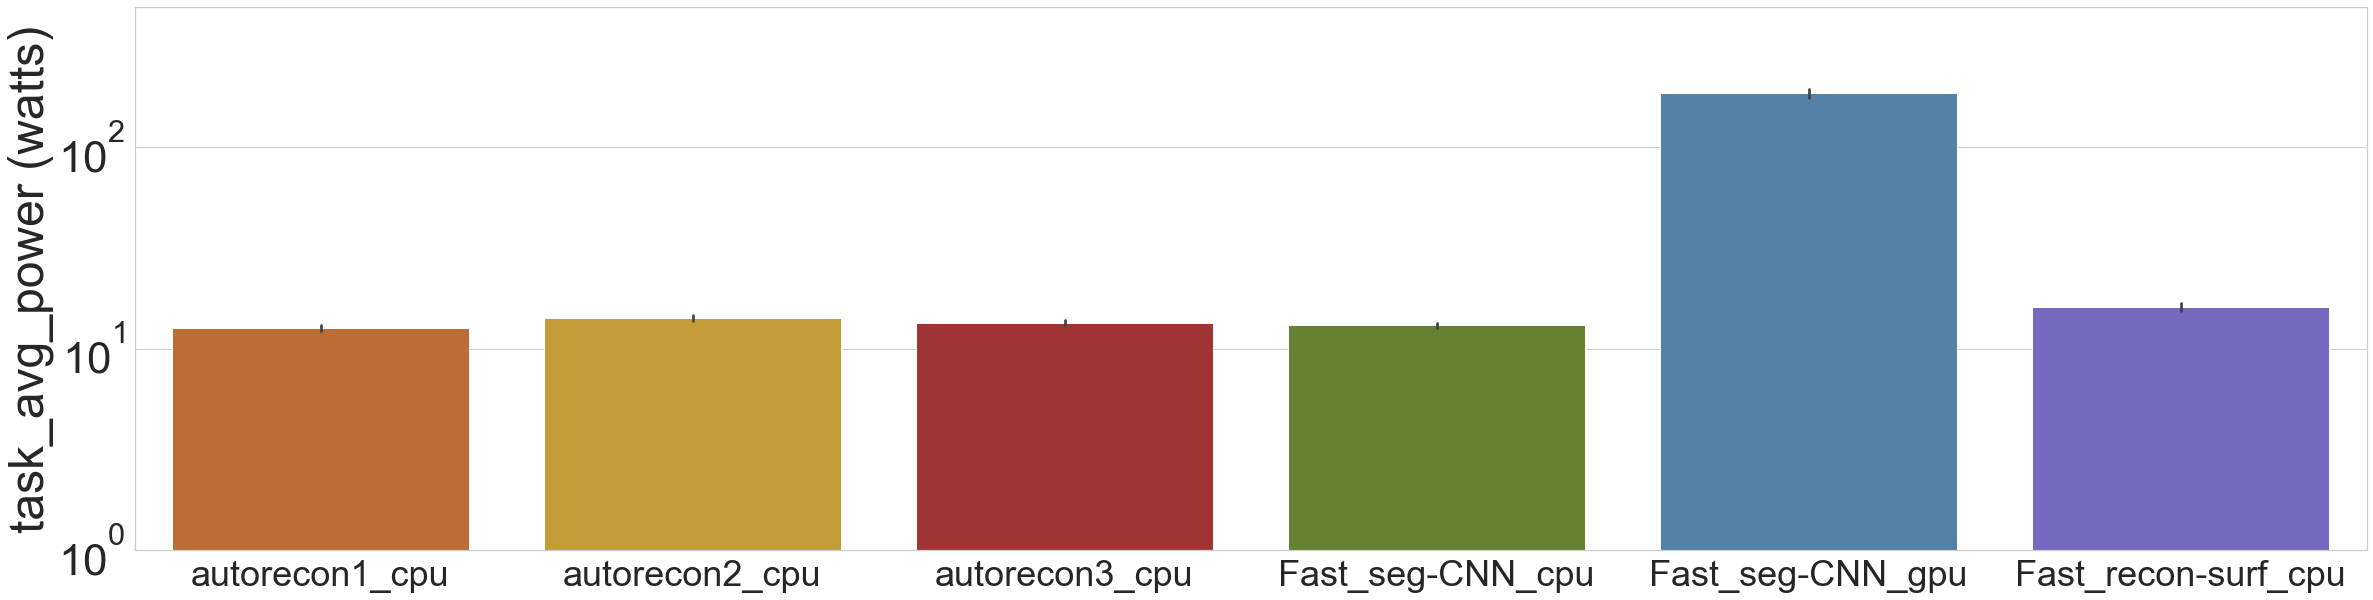

In [50]:
import copy

plot_df = flops_df_freesurfer.append(flops_df_fastsurfer).copy()
plot_df['task_duration (min)'] = plot_df['duration'] / 60
plot_df['task_duration (hr)'] = plot_df['duration'] /3600

plot_df['task_power (watt-hr)'] = plot_df['power'] * 1000
plot_df['task_avg_power (watts)'] = 1000 * plot_df['power'] / plot_df['task_duration (hr)'] 

sns.set(font_scale = 5)
freesurfer_pal = ['chocolate','goldenrod','firebrick']
fastsurfer_pal = ['olivedrab','steelblue','slateblue']
# with sns.axes_style("whitegrid"):
#     g = sns.catplot(y='power', x='task', hue='proc', kind='bar', data=plot_df, aspect=2)
#     g.set(yscale='log',ylim=[1, 1000000])

with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1,2, figsize=(40,18),sharex=True,sharey=True)
    ax = axes[0]
    df = plot_df[plot_df['experiment_set']=='FreeSurfer']
    g = sns.scatterplot(y='task_power (watt-hr)', x='task_duration (hr)', hue='task', s=50, data=df, ax=ax, palette=freesurfer_pal)
    g.set(xscale='log', yscale='log')
    ax.set_title('FreeSurfer')
    g = sns.kdeplot(y='task_power (watt-hr)', x='task_duration (hr)', hue='task', data=df, ax=ax, palette=freesurfer_pal)

    ax = axes[1]
    palette = sns.color_palette("husl",3)
    df = plot_df[(plot_df['experiment_set']=='FastSurfer')]
    hue_order = ['Fast_seg-CNN_cpu', 'Fast_seg-CNN_gpu', 'Fast_recon-surf_cpu']
    g = sns.scatterplot(y='task_power (watt-hr)', x='task_duration (hr)', hue='task', hue_order=hue_order, s=50, data=df, ax=ax, palette=fastsurfer_pal)
    g = sns.kdeplot(y='task_power (watt-hr)', x='task_duration (hr)', hue='task', hue_order=hue_order, data=df, ax=ax, palette=fastsurfer_pal,common_norm=False)
    g.set(xscale='log', yscale='log')
    ax.set_title('FastSurfer')

    plt.tight_layout()

sns.set(font_scale = 4)
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(40,10),sharex=True,sharey=True)
    palette = freesurfer_pal + fastsurfer_pal
    x_order = ['autorecon1_cpu', 'autorecon2_cpu', 'autorecon3_cpu', 'Fast_seg-CNN_cpu', 'Fast_seg-CNN_gpu', 'Fast_recon-surf_cpu']
    g = sns.barplot(y='task_avg_power (watts)', x='task', order=x_order, data=plot_df, ax=ax, palette=palette)
    g.set_xticklabels(g.get_xticklabels(),rotation=0,fontsize=36)
    g.set(yscale='log',ylim=[1, 500],xlabel = "")

### Power trace

In [13]:
experiment_set =  'recon-all' #'recon-all' #'fastsurfer_gpu_prune_0'
experiment_name = 1474044
use_cuda = False
plot_epochs = False

plot_df = power_df_concat_exp_set[(power_df_concat_exp_set['experiment_set']==experiment_set) & (power_df_concat_exp_set['experiment_name']==experiment_name)].copy()
total_power = tracker_summary_df_concat_exp_set[(tracker_summary_df_concat_exp_set['experiment_set']==experiment_set) & (tracker_summary_df_concat_exp_set['experiment_name']==experiment_name)]['total_power'].values[0]
PUE = tracker_summary_df_concat_exp_set[(tracker_summary_df_concat_exp_set['experiment_set']==experiment_set) & (tracker_summary_df_concat_exp_set['experiment_name']==experiment_name)]['PUE'].values[0]

sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(figsize=(15,5),sharex=False,sharey=False)

    g = sns.lineplot(plot_df['timestamp'],plot_df['total_power_per_timestep'].cumsum(),label='total attributed_power')

    if plot_epochs: 
        for e in epochs:
            g = plt.axvline(e, linestyle='-',c='purple')
        
    g = plt.axhline(total_power, linestyle='--',c='black',label='total power estimate')
    
    plt.ylabel('power_draws')
    plt.legend()


IndexError: index 0 is out of bounds for axis 0 with size 0

In [19]:
flight = 1984
car = 126000
nn = 626155

nn/car, nn/flight

(4.969484126984127, 315.6023185483871)